# Pairs Trading Implementation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import seaborn as sns

import Quandl
# import statsmodels.api as sm
# from scipy import stats
# from statsmodels.graphics.api import qqplot
# from statsmodels.graphics import tsaplots

/Users/bbahmany/Main/Programming/Git/quantitative-finance/qf-env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [13]:
%matplotlib inline
# plt.style.use('bmh');
# sns.set_style("whitegrid", {'axes.edgecolor': '.6', 'axes.facecolor': '0.9', 'grid.color': '.82'})
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 
                            'axes.facecolor': '0.9', 
                            'grid.color': '.82', 
                            'legend.frameon':True,
                            })

In [3]:
def get_adj_close(tickers, start="", end="", ratio=True):
    """
    Returns DataFrame with the adjusted close values for the 
        tickers passed in during the time frame specified
    """
    
    result = {}
    
    for ticker in tickers:
        try:
            result[ticker] = Quandl.get("WIKI/"+ticker, trim_start=start, trim_end=end)['Adj. Close']
        except DatasetNotFound:
            print(ticker, 'is not a vaild ticker')
            return
    
    if ratio:
        if result[tickers[0]].mean() > result[tickers[1]].mean():
            result[tickers[0]+'/'+tickers[1]] = result[tickers[0]]/result[tickers[1]]
        else:
            result[tickers[1]+'/'+tickers[0]] = result[tickers[1]]/result[tickers[0]]
    
    return pd.DataFrame(result).dropna()

In [6]:
cell = get_adj_close(['T', 'VZ'], start="1995-01-01")
#bev = get_adj_close(['PEP', 'KO'], start="1995-01-01")

In [5]:
assert cell.isnull().sum().all() == 0
#assert bev.isnull().sum().all() == 0

In [6]:
#bev.head()

In [7]:
cell.head(2)

,T,VZ,VZ/T
Date,,,
1995-01-03,8.755044,12.311591,1.406228
1995-01-04,8.663981,12.143038,1.401554


In [11]:
def plot_pair(df, names):
    """
    Plot pair series with name subsitutions
    """
    tick1 = df.columns[0]
    tick2 = df.columns[1]
    
    fig, ax = plt.subplots(figsize=(20,8));
    years = YearLocator();
    yearsFmt = DateFormatter('%Y');
    
    ax.xaxis.set_major_locator(years);
    ax.xaxis.set_major_formatter(yearsFmt);
    ax.autoscale_view();
    
    plt.title(names[tick1] + ' and ' + 
              names[tick2] +' (Adj. Close)', fontsize=20);
    plt.ylabel('Adj. Close', fontsize=15);
    plt.xlabel('Time', fontsize=15);
    
    ax.plot_date(df.index, df[tick1], 'indianred', label=names[tick1]);
    ax.plot_date(df.index, df[tick2], 'steelblue', label=names[tick2]);
    
    plt.legend(loc=2, prop={'size':15}, frameon=True);

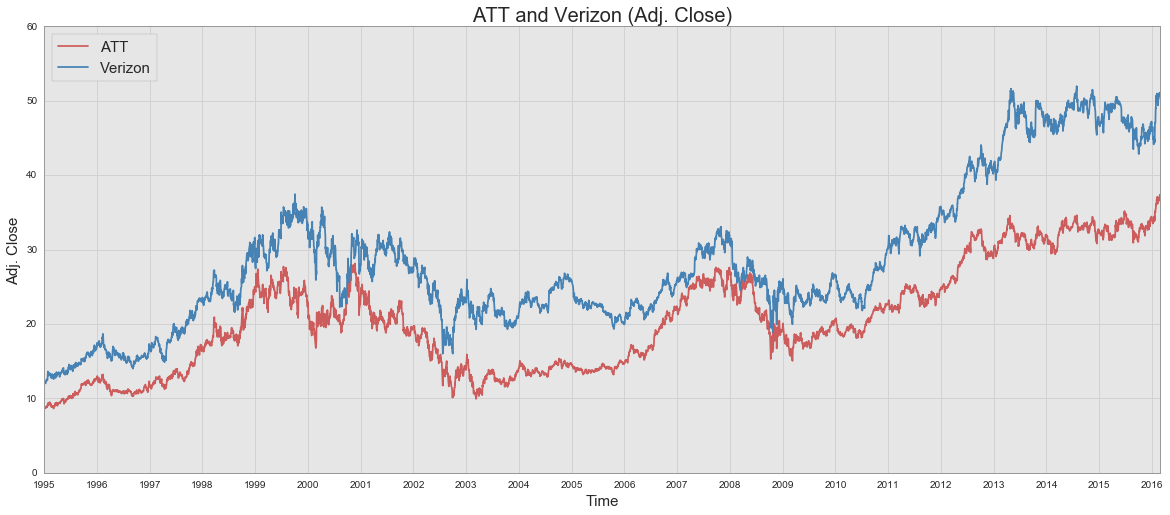

In [12]:
plot_pair(cell, {'T':'ATT', 'VZ':'Verizon'})

In [10]:
#plot_pair(bev, {'KO':'Coke', 'PEP':'Pepsi'})

In [11]:
def plot_ratio(ratio, name, deviations=[1], positions=[]):
    fig = plt.subplots(figsize=(20,8));

    plt.title('Ratio ' + name + ' Adjusted Close', fontsize=20);
    plt.ylabel('Ratio', fontsize=15);
    plt.xlabel('Time Index', fontsize=15);
    plt.xlim([0,ratio.size])
    plt.xticks(np.arange(0, ratio.size, 500))
    
    plt.plot(np.arange(ratio.size), ratio, 'black', label='$Ratio$', alpha=0.5);
    plt.plot([0, ratio.size], [ratio.mean(), ratio.mean()], 'steelblue', lw=2, label=r'$\hat{\mu}$');
    
    for color, std in zip(['y','orange','salmon','red'], deviations):
        latex_prep = '$' + str(std) + '$'
        plt.plot([0, ratio.size], [ratio.mean()-std*ratio.std(), ratio.mean()-std*ratio.std()], 
                 '--', lw=2, label='$\hat{\mu} \pm$' + latex_prep + '$\hat{\sigma}$', color=color);
        plt.plot([0, ratio.size], [ratio.mean()+std*ratio.std(), ratio.mean()+std*ratio.std()], 
                 '--', lw=2, color=color);
    
    if positions:
        opening_days, closing_days = [], []
        opening_ratios, closing_ratios = [], []
        
        for position in positions:
            opening_days.append(position['open'])
            closing_days.append(position['close'])
            opening_ratios.append(ratio.ix[position['open']])
            closing_ratios.append(ratio.ix[position['close']])
            
        plt.scatter(x=opening_days, y=opening_ratios, s=150, color='lime', edgecolor='black', label='$Open$ '+'$Position$')
        plt.scatter(x=closing_days, y=closing_ratios, s=150, color='red', edgecolor='black', label='$Close$ '+'$Position$')
    
    plt.legend(loc=1, prop={'size':15}, frameon=True);

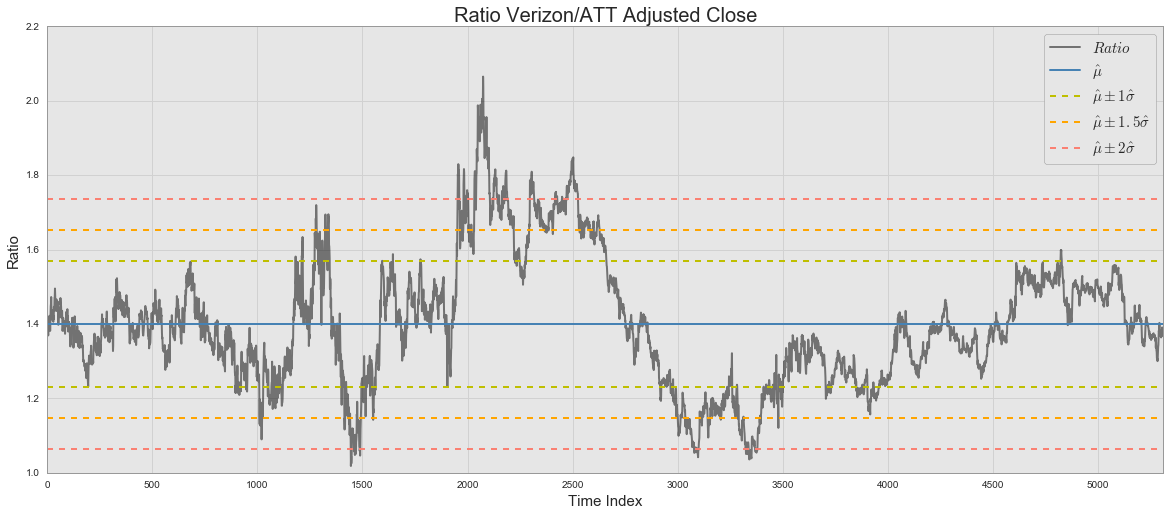

In [12]:
plot_ratio(cell['VZ/T'], name='Verizon/ATT', deviations=[1,1.5,2])

In [13]:
# fig = plt.figure(figsize=(20,10))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(avg_adj_close.dropna().values.squeeze(), lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(avg_adj_close.dropna().values, lags=40, ax=ax2)

In [14]:
# def moving_average(ts, theta1):
#     ma = pd.Series(index=ts.index, data=np.repeat(0, ts.size))
#     ma[0] = ts[0]
    
#     for idx in range(1,ts.size):
#         ma[idx] = theta1*ts[idx-1]
        
#     return ma

In [15]:
def identify_next_position(ratio, k, start=0):
    result = {}
    mean, sd = ratio.mean(), ratio.std()
    day, size = start, ratio.size
    
    while day < size:
        
        if ratio.ix[day] > mean + k*sd:
            result['open'] = day
            day += 1
            
            while day < size:
                if ratio.ix[day] <= mean:
                    result['close'] = day
                    return result
                day += 1
        
        elif ratio.ix[day] < mean - k*sd:
            result['open'] = day
            day += 1
            
            while day < size:
                if ratio.ix[day] >= mean:
                    result['close'] = day
                    return result
                day += 1
                
        day += 1
        
    return None

In [16]:
identify_next_position(cell['VZ/T'], 1)

{'close': 1171, 'open': 896}

In [17]:
# plot_ratio(cell['VZ/T'], 'Verizon/ATT', deviations=[1,2], positions=[identify_next_position(cell['VZ/T'], 1, 1171)])

In [18]:
def identify_all_positions(ratio, k, start=0):
    positions = []
    day, size = start, ratio.size
    
    while day < size:
        position = identify_next_position(ratio, k, day)
        
        if position:
            positions.append(position)
            day = position['close']
        else:
            break
    
    return positions

In [19]:
identify_all_positions(cell['VZ/T'], 1)[:3]

[{'close': 1171, 'open': 896},
 {'close': 1220, 'open': 1182},
 {'close': 1305, 'open': 1273}]

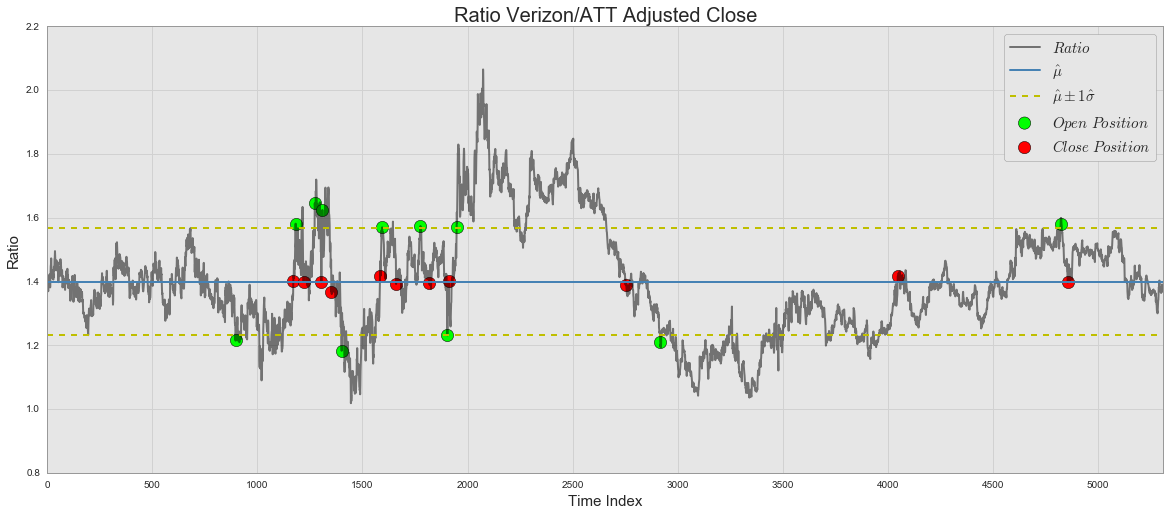

In [20]:
positions = identify_all_positions(cell['VZ/T'], 1)
plot_ratio(cell['VZ/T'], 'Verizon/ATT', deviations=[1], positions=positions)

In [23]:
positions

[{'close': 1171, 'open': 896},
 {'close': 1220, 'open': 1182},
 {'close': 1305, 'open': 1273},
 {'close': 1352, 'open': 1309},
 {'close': 1584, 'open': 1401},
 {'close': 1660, 'open': 1594},
 {'close': 1818, 'open': 1776},
 {'close': 1910, 'open': 1904},
 {'close': 2752, 'open': 1948},
 {'close': 4047, 'open': 2917},
 {'close': 4856, 'open': 4822}]

In [60]:
def trade(numer_prices, numer_shares, denom_prices, denom_shares, ratio, positions, swap_count=1):
    
    init_portfolio_value = numer_prices.ix[0]*numer_shares + denom_prices.ix[0]*denom_shares
    cur_portfolio_value = numer_prices.ix[0]*numer_shares + denom_prices.ix[0]*denom_shares
    
    for position in positions:
        if ratio.ix[position['open']] > ratio.mean():
            cur_portfolio_value += swap_count*numer_prices.ix[position['open']]
            cur_portfolio_value -= swap_count*denom_prices.ix[position['open']]
            cur_portfolio_value -= swap_count*numer_prices.ix[position['close']]
            cur_portfolio_value += swap_count*numer_prices.ix[position['close']]
        elif ratio.ix[position['open']] < ratio.mean():
            cur_portfolio_value -= swap_count*numer_prices.ix[position['open']]
            cur_portfolio_value += swap_count*denom_prices.ix[position['open']]
            cur_portfolio_value += swap_count*numer_prices.ix[position['close']]
            cur_portfolio_value -= swap_count*numer_prices.ix[position['close']]
    
    return {'init_portfolio_value': init_portfolio_value,
            'end_portfolio_value': cur_portfolio_value,
            'net_gain': cur_portfolio_value - init_portfolio_value,
            'net_gain/year': (cur_portfolio_value - init_portfolio_value) / (ratio.count() / 252) } 
            # 252 trade days / year

In [61]:
trade(cell['VZ'], 10000, cell['T'], 10000, cell['VZ/T'], positions, 2000)

{'end_portfolio_value': 346037.13179246144,
 'init_portfolio_value': 210666.35315637721,
 'net_gain': 135370.77863608423,
 'net_gain/year': 6424.3759352717934}

#### TODO
* off more shares as becomes more extreme
* dont off same shares everytime
* maybe close potentially open position
* real time updates (cron job)